# Introduction: #2 Data Preparation

In this notebook, we conduct data processing and data aggregation to generate data for visualization and further analysis.

The objective of this section is to create two datasets:
* `ecommerce_session.csv`: __customer & Session-level data__, including unique ID, geographic data, and device/web related information of customer/session; information for each session, including origin, number of unique pages, total time duration, total quantity of items, total revenue of all transactions, etc.
* `ecommerce_item.csv`: __item-level data__, including number of unique customers/sessions viewed this item, added this item to a cart, and purchased this item

After getting those two datasets, we are ready to perform exploratory data analysis to have a better understanding of this eCommerce business!

## Imports
We are using a typical data science stack such as `pandas`, `numpy`, `matplotlib`, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = [10,6]

## Read in Data 

First, we can find our raw data has __3,980,420 rows (event-level) and 37 variables__. Also, there are a total of __101798 customers and 128767 sessions__ in the data.

In [2]:
ecommerce_all = pd.read_csv('ecommerce_all.csv')
ecommerce_all['user_pseudo_id'] = ecommerce_all['user_pseudo_id'].astype(str)
ecommerce_all['ga_session_id'] = ecommerce_all['user_pseudo_id'].astype(str) + ecommerce_all['ga_session_id'].astype(str)
ecommerce_all['unique_session_id'] = ecommerce_all['event_date'].astype(str) + ecommerce_all['ga_session_id'].astype(str)
ecommerce_all.head()

,event_date,event_time,user_pseudo_id,continent,sub_continent,country,region,city,device_category,mobile_brand_name,mobile_model_name,operating_system,web_browser,revenue,traffic_name,traffic_medium,traffic_source,ga_session_id,event_name,event_value_in_usd,page_title,page_location,engagement_time_sec,total_item_quantity,purchase_revenue_in_usd,unique_items,transaction_id,item_id,item_name,item_brand,item_variant,item_category,price_in_usd,quantity,item_revenue_in_usd,promotion_name,unique_session_id
0,20201103,2020-11-03 11:04:19,8825068.227430915,Europe,Southern Europe,(not set),(not set),(not set),desktop,Apple,Safari,Web,Chrome,0.0,(organic),organic,google,8825068.2274309152661157188,view_item,NaN,Eco-Friendly | Google Merchandise Store,https://shop.googlemerchandisestore.com/Google...,3.075,NaN,NaN,12,(not set),GGOEGXXX1378,Google Cotopaxi Shell,(not set),(not set),Eco-Friendly,NaN,NaN,NaN,(not set),202011038825068.2274309152661157188
1,20201103,2020-11-03 07:43:31,10673312.893252771,Americas,Northern America,United States,Georgia,(not set),desktop,Google,Chrome,Web,Chrome,0.0,<Other>,cpc,google,10673312.8932527713880769201,view_item,NaN,Hats | Apparel | Google Merchandise Store,https://shop.googlemerchandisestore.com/Google...,3.354,NaN,NaN,12,(not set),GGOEYHPB121110,YouTube Leather Strap Hat Black,(not set),(not set),Home/Apparel/Hats/,NaN,NaN,NaN,(not set),2020110310673312.8932527713880769201
2,20201103,2020-11-03 13:50:36,15626554.576808145,Americas,Northern America,United States,New York,New York,mobile,Apple,iPhone,Web,Safari,0.0,(organic),organic,google,15626554.5768081458656175620,view_item,NaN,Home,https://shop.googlemerchandisestore.com/store....,7.324,1.0,NaN,12,(not set),GGOEGXXX1381,Google Men's Softshell Moss,(not set),(not set),Home/Shop by Brand/Google/,NaN,NaN,NaN,(not set),2020110315626554.5768081458656175620
3,20201103,2020-11-03 22:34:53,16462431.22835943,Americas,South America,Colombia,(not set),(not set),mobile,Apple,iPhone,Web,Safari,0.0,(direct),(none),(direct),16462431.228359436753782001,view_item,NaN,Men's / Unisex | Apparel | Google Merchandise ...,https://shop.googlemerchandisestore.com/Google...,22.694,NaN,NaN,12,(not set),GGOEGXXX1038,Google F/C Long Sleeve Tee Charcoal,(not set),(not set),Home/Apparel/Men's / Unisex/,NaN,NaN,NaN,(not set),2020110316462431.228359436753782001
4,20201103,2020-11-03 21:31:24,16765047.752179116,Americas,South America,Ecuador,Pichincha,Quito,desktop,Google,Chrome,Windows,Chrome,0.0,(referral),referral,shop.googlemerchandisestore.com,16765047.7521791163277028366,view_item,NaN,Home,https://shop.googlemerchandisestore.com/store....,2.811,NaN,NaN,12,(not set),GGOEGXXX1347,Google Sherpa Zip Hoodie Navy,(not set),(not set),Home/Apparel/Men's / Unisex/,NaN,NaN,NaN,(not set),2020110316765047.7521791163277028366


In [3]:
print('Customer Count: ', ecommerce_all.user_pseudo_id.nunique())
print('Session Count: ', ecommerce_all.unique_session_id.nunique())
print('(rows, columns): ', ecommerce_all.shape)

Customer Count:  101798
Session Count:  128767
(rows, columns):  (3980420, 37)


## Customer & Session Data

Columns/Attributes about __customers__:
* `event_date`, `user_pseudo_id`, `ga_session_id`: datetime and unique ID of customer/session
* `user_pseudo_id`, `ga_session_id`: unique ID of customer/session
* `continent`, `sub_continent`, `country`, `region`, `city` : geographic data
* `device_category`, `mobile_brand_name`, `mobile_model_name`, `operating_system`, `web_browser`: device/web related information

Columns/Attributes related to __sessions__:
* `traffic` : the origin through which customer found the site in this session, including name, medium and source
* `total_unique_page_count`: number of unique pages customers engaged in this session
* `total_engagement_time`: total time duration of this session in seconds
* `total_item_quantity`: __(if purchased)__ total quantity of items of all transactions in this session
* `total_unique_items`: __(if purchased)__ number of unique items purchased in this session
* `total_purchase_revenue`: __(if purchased)__ total revenue of all transactions in this session
* `promotion_or_not`: whether customer responded to internal promotions in this session

In [4]:
# event_date, user_pseudo_id, ga_session_id
ecommerce_session = ecommerce_all[['event_date', 'continent', 'sub_continent', 'country', 'user_pseudo_id', 'ga_session_id', 'unique_session_id', 
                                   'device_category', 'mobile_brand_name', 'mobile_model_name', 'operating_system', 'web_browser',
                                   'traffic_name', 'traffic_medium', 'traffic_source']].drop_duplicates()

# total_unique_page_count
total_unique_page_count = ecommerce_all.groupby(['event_date', 'user_pseudo_id', 'ga_session_id'])['page_title'].agg('nunique').\
                          reset_index().rename(columns={'page_title':'total_unique_page_count'})

# engagement_time_sec
engagement_time_sec = ecommerce_all.groupby(['event_date', 'user_pseudo_id', 'ga_session_id'])['engagement_time_sec'].agg('sum').\
                      reset_index().rename(columns={'engagement_time_sec':'total_engagement_time'})

# total_item_quantity
total_item_quantity = ecommerce_all[ecommerce_all.event_name == 'purchase'].groupby(['event_date', 'user_pseudo_id', 'ga_session_id'])['total_item_quantity'].agg('sum').\
                      reset_index().rename(columns={'total_item_quantity':'total_item_quantity'})

# total_unique_items
total_unique_items = ecommerce_all[ecommerce_all.event_name == 'purchase'].groupby(['event_date', 'user_pseudo_id', 'ga_session_id'])['unique_items'].agg('sum').\
                     reset_index().rename(columns={'unique_items':'total_unique_items'})

# total_purchase_revenue
total_purchase_revenue = ecommerce_all[ecommerce_all.event_name == 'purchase'].groupby(['event_date', 'user_pseudo_id', 'ga_session_id'])['purchase_revenue_in_usd'].agg('sum').\
                         reset_index().rename(columns={'purchase_revenue_in_usd':'total_purchase_revenue'})

# promotion_or_not
temp = ecommerce_all.copy()
temp['promotion_or_not'] = temp['promotion_name'].apply(lambda x: 1 if ((x == 'Google Mural Collection') | 
                                                                        (x == 'Act Responsible') |
                                                                        (x == 'Reach New Heights') |
                                                                        (x == 'Complete Your Collection')) else 0)
promotion_or_not = temp.groupby(['event_date', 'continent', 'sub_continent', 'user_pseudo_id', 'ga_session_id'])['promotion_or_not'].agg('sum').\
                   reset_index().rename(columns={'promotion_or_not':'promotion_or_not'})
promotion_or_not['promotion_or_not'] = promotion_or_not['promotion_or_not'].apply(lambda x: 'No' if x == 0 else 'Yes')

# final data
ecommerce_session = ecommerce_session.merge(total_unique_page_count).merge(engagement_time_sec).merge(total_item_quantity, how='outer')\
                                     .merge(total_purchase_revenue, how='outer').merge(total_unique_items, how='outer').merge(promotion_or_not).fillna(0)
ecommerce_session.head()

,event_date,continent,sub_continent,country,user_pseudo_id,ga_session_id,unique_session_id,device_category,mobile_brand_name,mobile_model_name,operating_system,web_browser,traffic_name,traffic_medium,traffic_source,total_unique_page_count,total_engagement_time,total_item_quantity,total_purchase_revenue,total_unique_items,promotion_or_not
0,20201103,Europe,Southern Europe,(not set),8825068.227430915,8825068.2274309152661157188,202011038825068.2274309152661157188,desktop,Apple,Safari,Web,Chrome,(organic),organic,google,2,42.284,0.0,0.0,0.0,Yes
1,20201103,Americas,Northern America,United States,10673312.893252771,10673312.8932527713880769201,2020110310673312.8932527713880769201,desktop,Google,Chrome,Web,Chrome,<Other>,cpc,google,2,83.642,0.0,0.0,0.0,Yes
2,20201103,Americas,Northern America,United States,15626554.576808145,15626554.5768081458656175620,2020110315626554.5768081458656175620,mobile,Apple,iPhone,Web,Safari,(organic),organic,google,3,5063.172,0.0,0.0,0.0,No
3,20201103,Americas,South America,Colombia,16462431.22835943,16462431.228359436753782001,2020110316462431.228359436753782001,mobile,Apple,iPhone,Web,Safari,(direct),(none),(direct),4,869.770,1.0,30.0,1.0,Yes
4,20201103,Americas,South America,Ecuador,16765047.752179116,16765047.7521791163277028366,2020110316765047.7521791163277028366,desktop,Google,Chrome,Windows,Chrome,(referral),referral,shop.googlemerchandisestore.com,1,1196.511,0.0,0.0,0.0,Yes


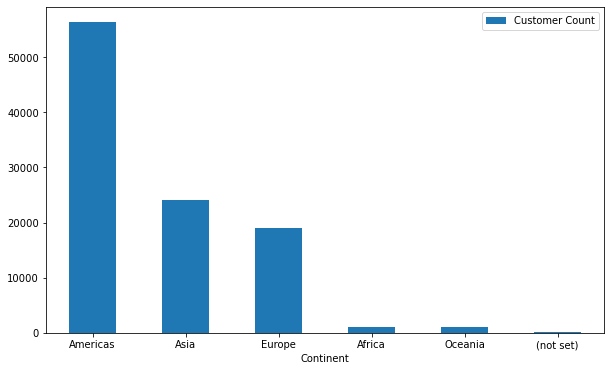

In [5]:
# distribution of continents by customer count 
df = ecommerce_session.groupby(['continent'])['user_pseudo_id'].agg('nunique').reset_index().\
     rename(columns={'continent':'Continent','user_pseudo_id':'Customer Count'}).sort_values(by='Customer Count', ascending=False)

ax = df.plot.bar(x='Continent', y='Customer Count', rot=0)

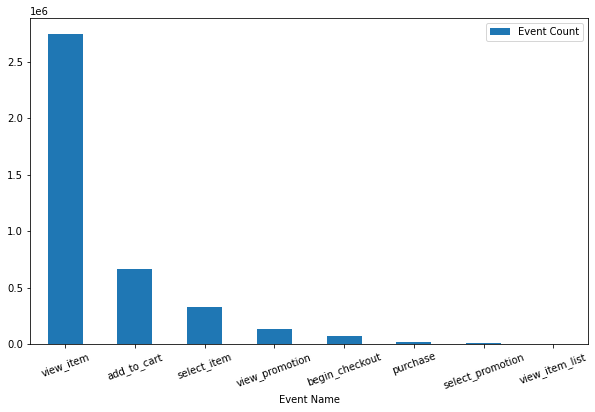

In [6]:
# distribution of events by event count
df = ecommerce_all.groupby(['event_name'])['user_pseudo_id'].agg('count').reset_index().\
     rename(columns={'event_name':'Event Name','user_pseudo_id':'Event Count'}).sort_values(by='Event Count', ascending=False)

ax = df.plot.bar(x='Event Name', y='Event Count', rot=20)

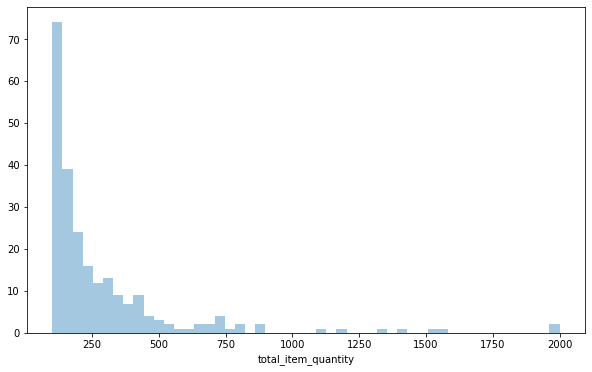

In [7]:
# distribution of total item quantity by session count (which quantity more than 100)
plot = sns.distplot(ecommerce_session[ecommerce_session['total_item_quantity'] > 100]['total_item_quantity'], bins=50, kde=False)

In [8]:
ecommerce_session.to_csv('ecommerce_session.csv', index=False)

## Item Data
* `event_date`, `ga_session_id`: datetime and unique ID of session
* `promotion_or_not`: whether customer responded to internal promotions while engaging with this item
* `total_view_customers`, `total_view_sessions` : __(if viewed)__ number of unique customers/sessions viewed this item
* `total_add_to_cart_customers`, `total_add_to_cart_sessions`: __(if added)__ number of unique customers/sessions added this item to cart
* `total_purchase_customers`, `total_purchase_sessions`: __(if purchased)__ number of unique customers/sessions purchased this item
* `total_purchase_quantity`, `total_item_revenue`: __(if purchased)__ total quantity/revenue this item was purchased

In [9]:
### add column item_category to categorize items based on categories on the website

# read in data for mapping 
item_category_mapping_df = pd.read_csv('item_category_mapping_df.csv')

# merge data to get item_category
item_events = ecommerce_all.merge(item_category_mapping_df, on=['item_category'], how='left')


### add column promotion_or_not to identify whether customer responded to internal promotions while engaging with this item

# add unique_session_id for identifying same session in different event date
promotion_or_not['unique_session_id'] = promotion_or_not['event_date'].astype(str) + promotion_or_not['ga_session_id'].astype(str)
item_events['unique_session_id'] = item_events['event_date'].astype(str) + item_events['ga_session_id'].astype(str)

# get unique_session_id of sessions with promotions as well as that of sessions with promotions
sessions_with_promotion_list = promotion_or_not[promotion_or_not['promotion_or_not'] == 'Yes']['unique_session_id'].tolist()
sessions_without_promotion_list = promotion_or_not[promotion_or_not['promotion_or_not'] == 'No']['unique_session_id'].tolist()

# if the customer responded to a internal promotion for only one of all items in a session, promotion_or_not = 'Yes'
# because this customer had responded to promotion before purchasing other items
item_events.loc[item_events.unique_session_id.isin(sessions_with_promotion_list), 'promotion_or_not'] = 'Yes'
item_events.loc[item_events.unique_session_id.isin(sessions_without_promotion_list), 'promotion_or_not'] = 'No'

In [10]:
### view events
view_item_events = item_events[((item_events.event_name == 'view_item') | (item_events.event_name == 'select_item')) &
                               (item_events.item_category.isnull() == False)]

# total_view_customers
total_view_customers = view_item_events.groupby(['event_date', 'continent', 'sub_continent', 'promotion_or_not', 'item_category_new', 'item_name'])['user_pseudo_id'].agg('nunique').\
                       reset_index().rename(columns={'user_pseudo_id':'total_view_customers'})

# total_view_sessions
total_view_sessions = view_item_events.groupby(['event_date', 'continent', 'sub_continent', 'promotion_or_not', 'item_category_new', 'item_name'])['unique_session_id'].agg('nunique').\
                      reset_index().rename(columns={'unique_session_id':'total_view_sessions'})

# view item data
view_item = total_view_customers.merge(total_view_sessions)


### add_to_cart events
add_to_cart_item_events = item_events[(item_events.event_name == 'add_to_cart')]

# total_add_to_cart_customers
total_add_to_cart_customers = add_to_cart_item_events.groupby(['event_date', 'continent', 'sub_continent', 'promotion_or_not', 'item_category_new', 'item_name'])['user_pseudo_id'].agg('nunique').\
                              reset_index().rename(columns={'user_pseudo_id':'total_add_to_cart_customers'})

# total_add_to_cart_sessions
total_add_to_cart_sessions = add_to_cart_item_events.groupby(['event_date', 'continent', 'sub_continent', 'promotion_or_not', 'item_category_new', 'item_name'])['unique_session_id'].agg('nunique').\
                             reset_index().rename(columns={'unique_session_id':'total_add_to_cart_sessions'})

# add_to_cart item data
add_to_cart_item = total_add_to_cart_customers.merge(total_add_to_cart_sessions)


### purchase events
purchase_item_events = item_events[(item_events.event_name == 'purchase')]

# total_purchase_customers
total_purchase_customers = purchase_item_events.groupby(['event_date', 'continent', 'sub_continent', 'promotion_or_not', 'item_category_new', 'item_name'])['user_pseudo_id'].agg('nunique').\
                           reset_index().rename(columns={'user_pseudo_id':'total_purchase_customers'})

# total_purchase_sessions
total_purchase_sessions = purchase_item_events.groupby(['event_date', 'continent', 'sub_continent', 'promotion_or_not', 'item_category_new', 'item_name'])['unique_session_id'].agg('nunique').\
                          reset_index().rename(columns={'unique_session_id':'total_purchase_sessions'})

# total_purchase_quantity
total_purchase_quantity = purchase_item_events.groupby(['event_date', 'continent', 'sub_continent', 'promotion_or_not', 'item_category_new', 'item_name'])['quantity'].agg('sum').\
                          reset_index().rename(columns={'quantity':'total_purchase_quantity'})

# total_item_revenue
total_item_revenue = purchase_item_events.groupby(['event_date', 'continent', 'sub_continent', 'promotion_or_not', 'item_category_new', 'item_name'])['item_revenue_in_usd'].agg('sum').\
                     reset_index().rename(columns={'item_revenue_in_usd':'total_item_revenue'})

# purchase item data
purchase_item = total_purchase_customers.merge(total_purchase_sessions).merge(total_purchase_quantity).merge(total_item_revenue)


### final data
ecommerce_item = view_item.merge(add_to_cart_item, how='outer').merge(purchase_item, how='outer').fillna(0)
ecommerce_item.head()

,event_date,continent,sub_continent,promotion_or_not,item_category_new,item_name,total_view_customers,total_view_sessions,total_add_to_cart_customers,total_add_to_cart_sessions,total_purchase_customers,total_purchase_sessions,total_purchase_quantity,total_item_revenue
0,20201101,Africa,Northern Africa,Yes,Campus Collection,Google Cambridge Campus Bottle,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20201101,Africa,Northern Africa,Yes,Campus Collection,Google Cambridge Campus Ladies Tee,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20201101,Africa,Northern Africa,Yes,Campus Collection,Google Cambridge Campus Lapel Pin,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20201101,Africa,Northern Africa,Yes,Campus Collection,Google Cambridge Campus Mug,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20201101,Africa,Northern Africa,Yes,Campus Collection,Google Cambridge Campus Sticker,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


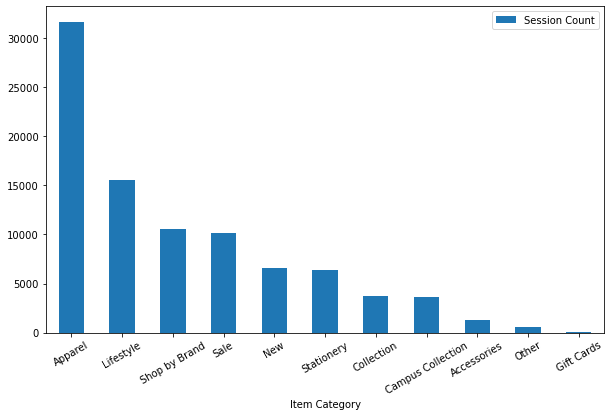

In [11]:
# distribution of item categories by session count 
df = item_events.groupby(['item_category_new'])['unique_session_id'].agg('nunique').reset_index().\
     rename(columns={'item_category_new':'Item Category','unique_session_id':'Session Count'}).sort_values(by='Session Count', ascending=False)

ax = df.plot.bar(x='Item Category', y='Session Count', rot=30)

In [12]:
ecommerce_item.to_csv('ecommerce_item.csv', index=False)